In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [3]:
X_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/X_train_processed.pkl")
y_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/y_train_over.pkl")

In [4]:
X_train.drop(columns=["date"], inplace=True)

In [5]:
clf_sag = LogisticRegression(solver='sag', random_state=0)

In [7]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve All variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [8]:
def compute_roc_auc(index):
    y_predict_prob = clf_sag.predict_proba(X_train.iloc[index])[:,1]
    y_predict = clf_sag.predict(X_train.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

In [9]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

In [10]:
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf_sag.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

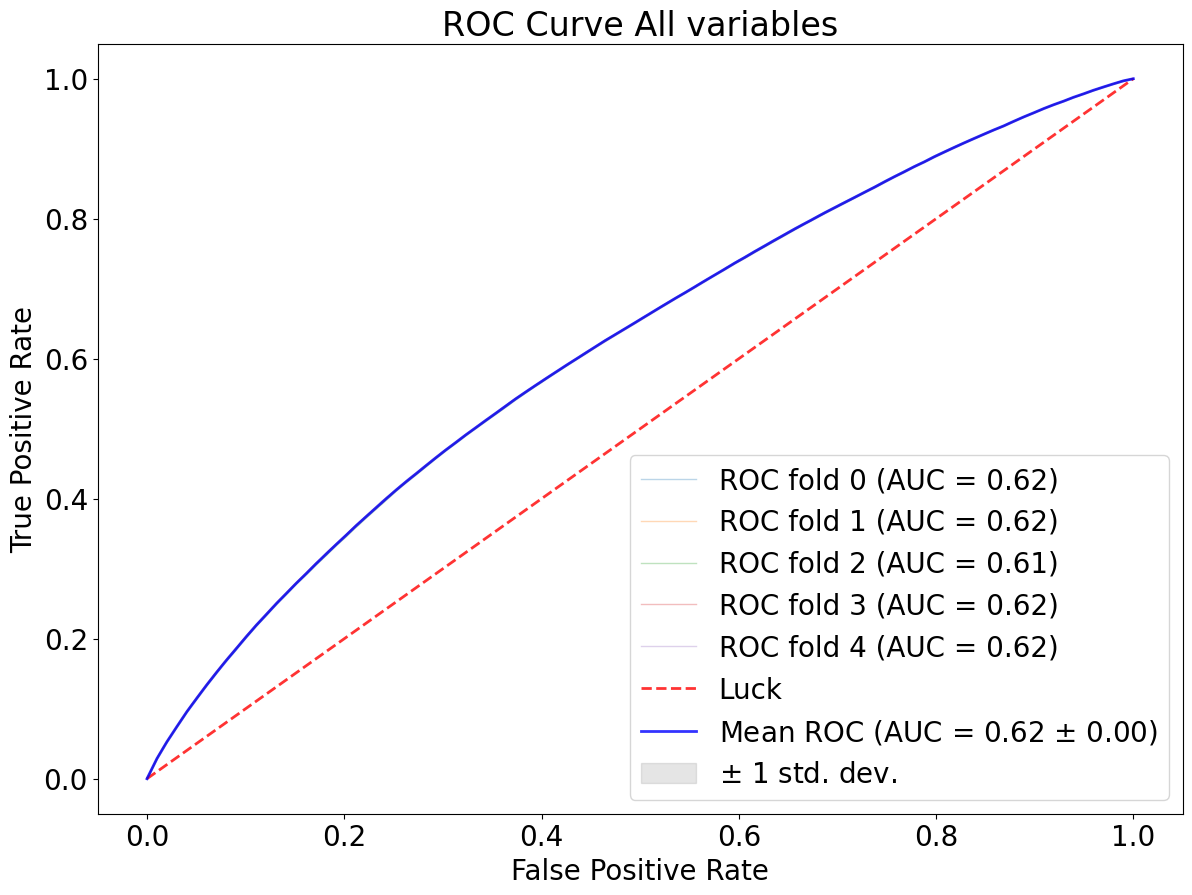

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.615589,0.615803,0.582827,0.582811,0.581872,0.581832,0.588661,0.588789
1,0.615651,0.615694,0.582848,0.582654,0.581760,0.581462,0.589499,0.589963
2,0.615833,0.614889,0.582916,0.582390,0.581823,0.581419,0.589592,0.588354
3,0.615603,0.615823,0.582737,0.583110,0.581662,0.582214,0.589317,0.588562
4,0.615585,0.615924,0.582784,0.583286,0.581707,0.582023,0.589377,0.590987


In [11]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [12]:
clf_sag.classes_

array([False,  True])

In [13]:
# change solver to liblinear
clf_ll = LogisticRegression(solver='liblinear', random_state=0)

In [14]:
def compute_roc_auc(index):
    y_predict_prob = clf_ll.predict_proba(X_train.iloc[index])[:,1]
    y_predict = clf_ll.predict(X_train.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf_ll.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

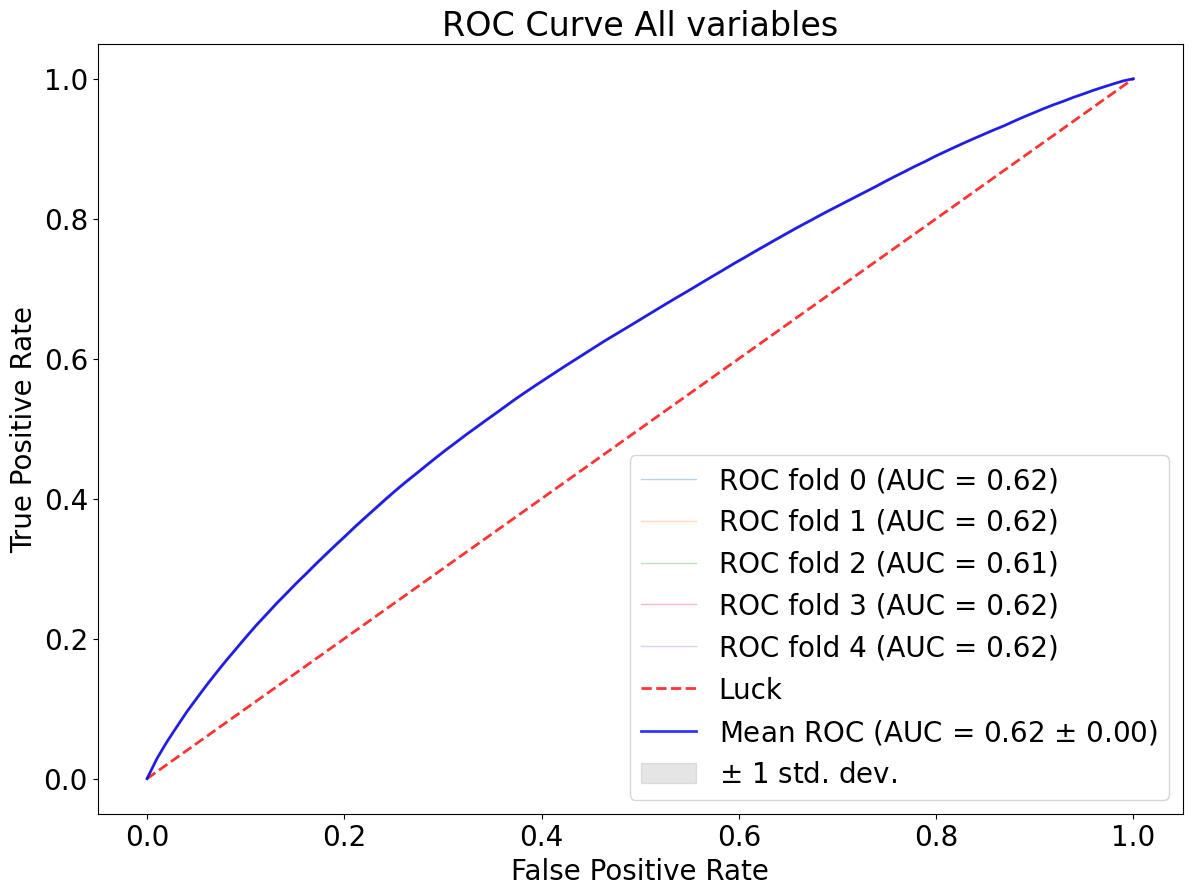

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.615589,0.615803,0.582843,0.582824,0.581902,0.581859,0.588592,0.588716
1,0.615649,0.615689,0.582844,0.582648,0.581756,0.581457,0.589499,0.589953
2,0.615834,0.614889,0.582900,0.582380,0.581803,0.581406,0.589601,0.588363
3,0.615603,0.615823,0.582732,0.583111,0.581651,0.582210,0.589353,0.588596
4,0.615585,0.615924,0.582775,0.583272,0.581707,0.582017,0.589310,0.590924


In [15]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [16]:
# change solver to newton-cholesky
clf_nc = LogisticRegression(solver='newton-cholesky', random_state=0)

In [17]:
def compute_roc_auc(index):
    y_predict_prob = clf_nc.predict_proba(X_train.iloc[index])[:,1]
    y_predict = clf_nc.predict(X_train.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf_nc.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

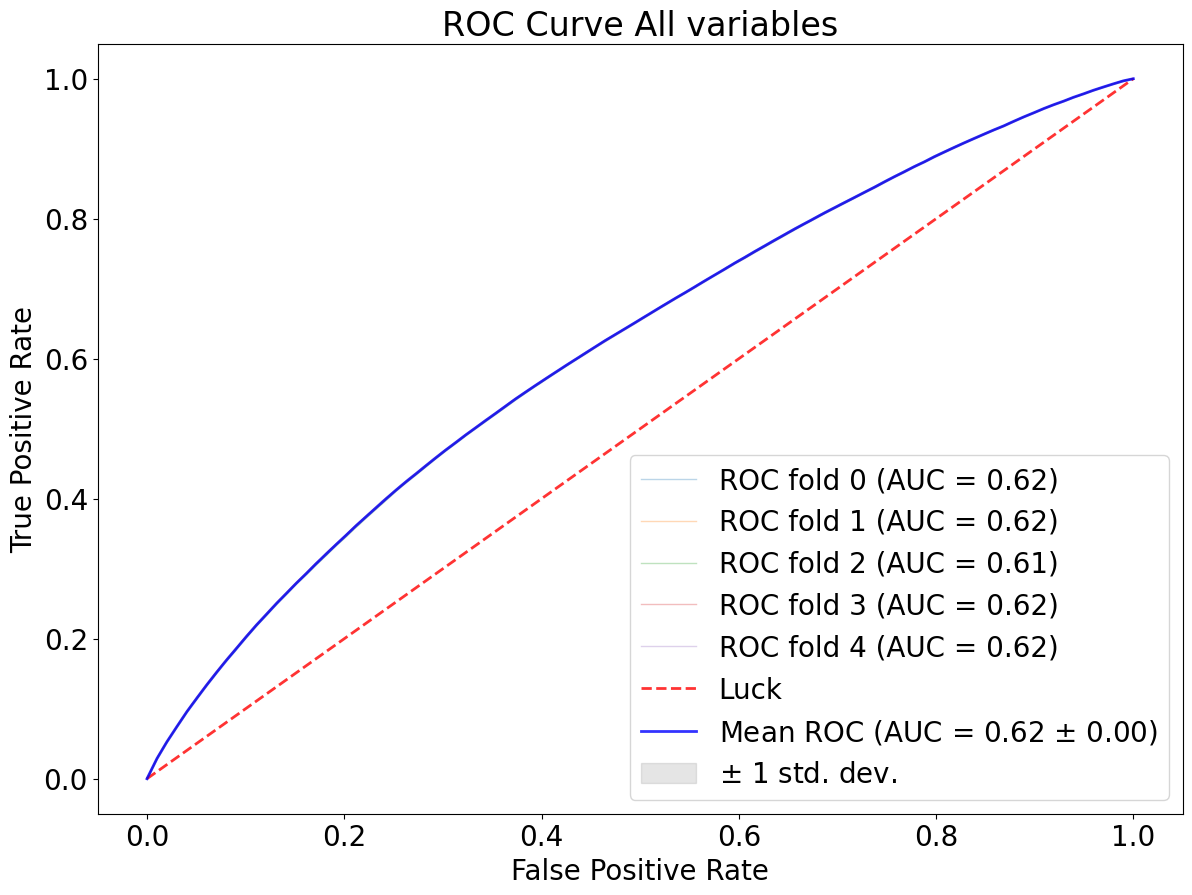

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.615588,0.615803,0.582838,0.582818,0.581895,0.581852,0.588596,0.588718
1,0.615651,0.615694,0.582843,0.582654,0.581753,0.581461,0.589509,0.589973
2,0.615833,0.614889,0.582900,0.582380,0.581804,0.581406,0.589601,0.588363
3,0.615603,0.615822,0.582732,0.583109,0.581650,0.582207,0.589361,0.588596
4,0.615585,0.615924,0.582792,0.583294,0.581721,0.582035,0.589348,0.590965


In [18]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [19]:
# selected variables
X_train_2 = X_train[['relative_humidity',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

In [20]:
clf_2 = LogisticRegression(solver='newton-cholesky', random_state=0)

In [21]:
def compute_roc_auc(index):
    y_predict_prob = clf_2.predict_proba(X_train_2.iloc[index])[:,1]
    y_predict = clf_2.predict(X_train_2.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_2, y_train), range(5)):
    clf_2.fit(X_train_2.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

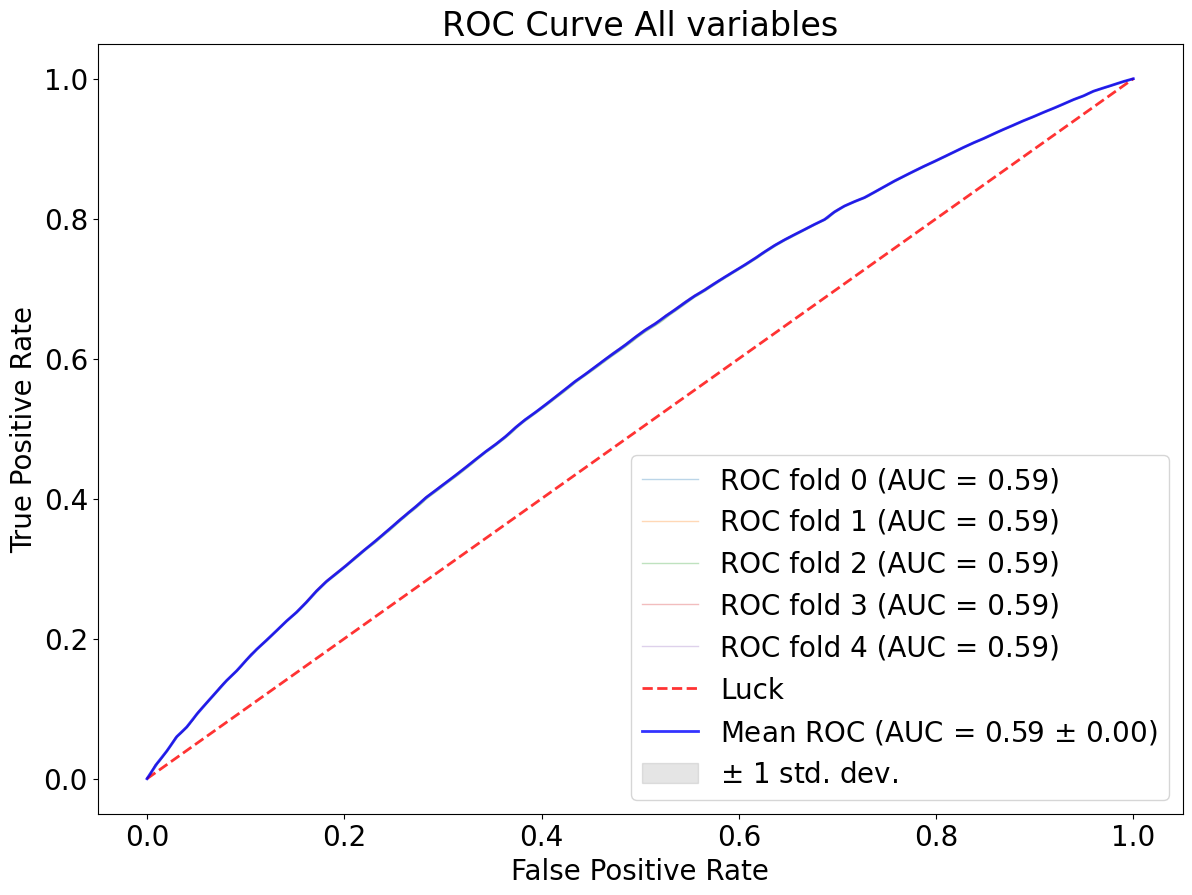

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.593838,0.594280,0.567764,0.568279,0.559472,0.559980,0.637480,0.637449
1,0.593914,0.594175,0.567973,0.567713,0.559390,0.559183,0.640235,0.639778
2,0.594254,0.592599,0.568256,0.566643,0.559944,0.558496,0.637592,0.636285
3,0.593808,0.594393,0.567829,0.568498,0.559414,0.560016,0.638646,0.639164
4,0.593909,0.594183,0.567846,0.568382,0.559494,0.559898,0.638036,0.639209


In [22]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [23]:
# feature selection
X_train_3 = X_train[['temperature', 'relative_humidity',
       'month_APR', 'month_AUG', 'month_JAN',
       'month_JUL', 'month_NOV',
       'month_OCT', 
       'destination_region_BRUSSELS-CAPITAL REGION',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS', 'departure_region_WALLONIA',
       'time_of_day_morning',
       'day_of_week_Saturday', 'day_of_week_Sunday']]

In [24]:
clf_3 = LogisticRegression(solver='newton-cholesky', random_state=0)

In [25]:
def compute_roc_auc(index):
    y_predict_prob = clf_3.predict_proba(X_train_3.iloc[index])[:,1]
    y_predict = clf_3.predict(X_train_3.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_3, y_train), range(5)):
    clf_3.fit(X_train_3.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

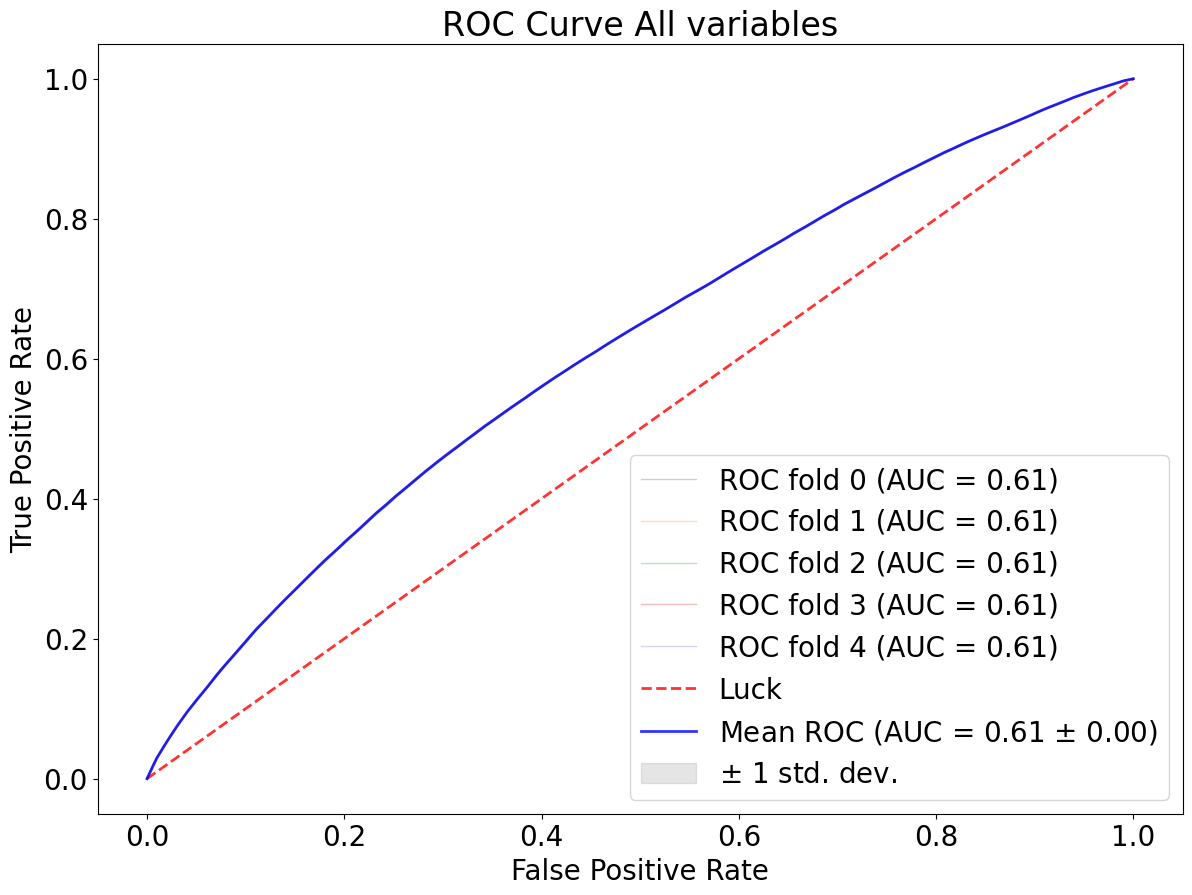

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.610772,0.611092,0.578795,0.578960,0.576716,0.576912,0.592342,0.592270
1,0.610833,0.611065,0.578869,0.578281,0.576639,0.575955,0.593419,0.593585
2,0.611026,0.610207,0.578833,0.578754,0.576637,0.576567,0.593163,0.593039
3,0.610885,0.610804,0.578819,0.578955,0.576626,0.576974,0.593128,0.591828
4,0.610811,0.611096,0.578803,0.579031,0.576622,0.576713,0.593036,0.594140


In [26]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [26]:
print(clf_fs.coef_, clf_fs.intercept_)

[[-0.06021902 -0.17499063 -0.39094894  0.02018384  0.03768194 -0.06905841
  -0.29470094  0.1206641  -0.03676731  0.02631594  0.3825675   0.27924
   0.0929468   0.05341761 -0.02160943 -0.0386743  -0.38491969  0.09754208
   0.28051149]] [-0.00686612]


In [31]:
pd.DataFrame({'Actual':y_train, 'Predicted': clf_fs.predict(X_train_fs)})

,Actual,Predicted
0,False,True
1,False,True
2,False,True
3,False,True
4,False,False
...,...,...
4130089,True,True
4130090,True,True
4130091,True,False
4130092,True,True


In [32]:
clf_fs.intercept_

array([-0.00686612])